In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import pyfoal

/home/max/conda/envs/pyfoal/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Configuration name
pyfoal.CONFIG = 'radtts-trf1-mrf9-512-4x512-temp0005-noloud'

# Whether to allow silent tokens on loud frames
pyfoal.ALLOW_LOUD_SILENCE = False

# Kernel sizes for the mel encoder
pyfoal.MEL_ENCODER_KERNEL_SIZES = [3, 3, 3, 3]

# Mel layer widths
pyfoal.MEL_ENCODER_WIDTHS = [512, 512, 512]

# Width of the phoneme embedding
pyfoal.PHONEME_EMBEDDING_SIZE = 512

# Threshold below which audio is considered silent
pyfoal.SILENCE_THRESHOLD = -60.  # dB

# Sampling temperature
pyfoal.TEMPERATURE = .0005

# Kernel sizes for the text encoder
pyfoal.TEXT_ENCODER_KERNEL_SIZES = [1, 1, 1, 1, 1]


In [12]:
gpu = 0
device = torch.device('cpu' if gpu is None else f'cuda:{gpu}')
loader = pyfoal.data.loader(['arctic'], 'test', gpu)
checkpoint = '/home/max/pyfoal/runs/radtts-trf1-mrf9-512-4x512-temp0005-noloud/00250000.pt'

In [13]:
for phonemes, audio, priors, mask, phoneme_lengths, frame_lengths, stems, alignments, texts in loader:
    
    # Infer
    logits = pyfoal.infer(
        phonemes.to(device),
        audio.to(device),
        checkpoint)
    
    break

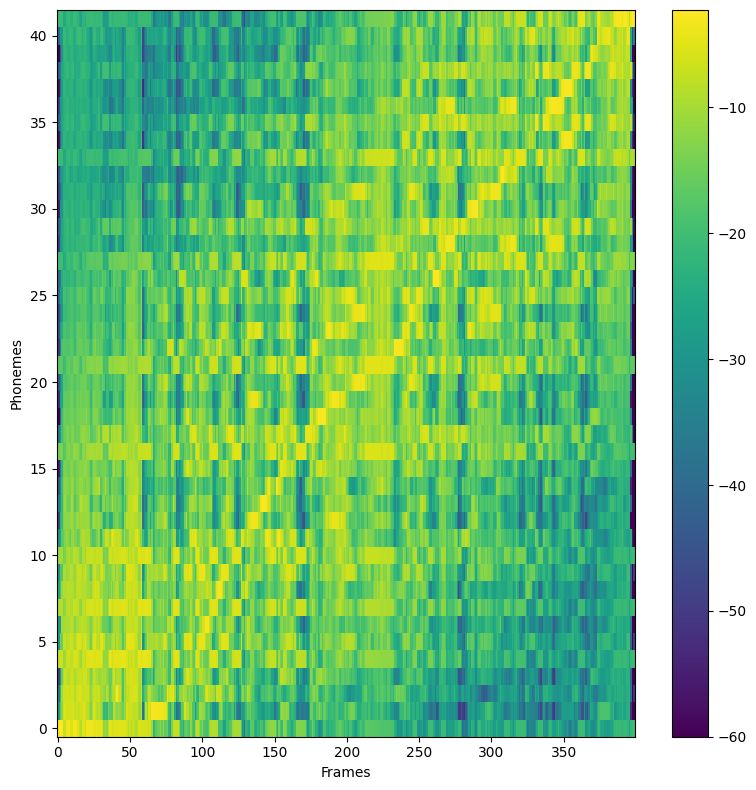

In [14]:
display = logits.clone()
display[display < -60.] = -60.
figure = pyfoal.plot.logits(display[0].cpu())

In [169]:
pyfoal.INTERPOLATE = True
alignment, times = pyfoal.postprocess(phonemes[0], logits[0], audio[0])
target = alignments[0]

In [170]:
times

tensor([0.0000, 0.6318, 0.7618, 0.8838, 0.9838, 1.0338, 1.0938, 1.1638, 1.2038,
        1.3438, 1.4338, 1.4938, 1.5838, 1.7038, 1.7338, 1.8438, 1.9238, 2.0538,
        2.2738, 2.4538, 2.4938, 2.5538, 2.6638, 2.7138, 2.8150, 2.9150, 2.9950,
        3.1550, 3.3050, 3.3950, 3.5049, 3.6049, 3.6749, 3.8149, 3.8549, 3.9649,
        4.1249])

In [165]:
def alignment_to_indices(x, align):
    hopsize = pyfoal.HOPSIZE / pyfoal.SAMPLE_RATE
    times = hopsize / 2 + torch.arange(len(x)) * hopsize
    phonemes = pyfoal.convert.alignment_to_indices(
        align,
        hopsize,
        times=times)
    _, indices = torch.unique_consecutive(
        torch.tensor(phonemes),
        return_inverse=True)
    return indices
align_indices = alignment_to_indices(logits[0], alignment)
target_indices = alignment_to_indices(logits[0], target)

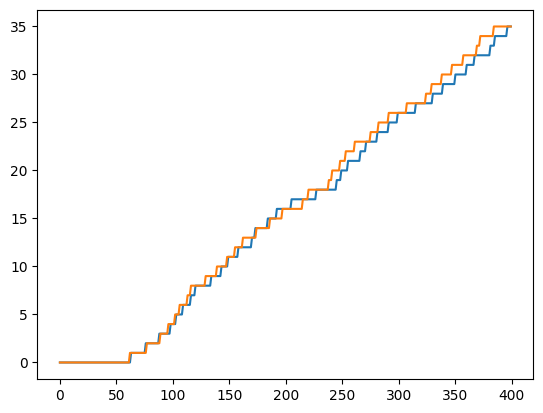

In [166]:
plt.plot(align_indices)
plt.plot(target_indices)

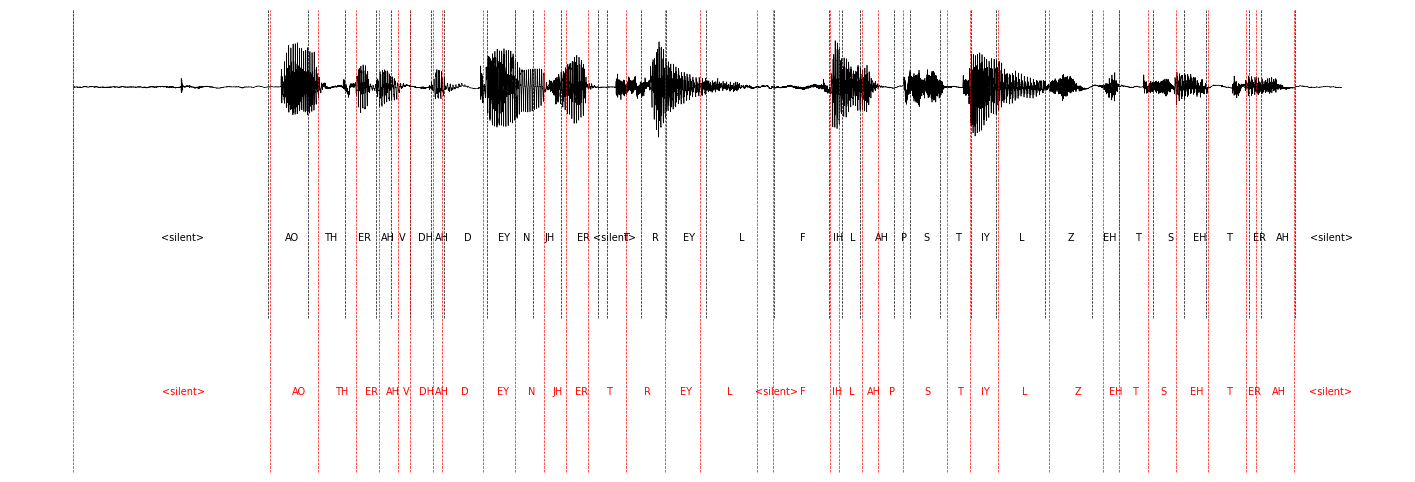

In [167]:
pyfoal.plot.alignment(audio, alignment, target).show()

In [168]:
[p.duration() for p in alignment.phonemes()]

[tensor(0.6318),
 tensor(0.1300),
 tensor(0.1220),
 tensor(0.1000),
 tensor(0.0500),
 tensor(0.0600),
 tensor(0.0700),
 tensor(0.0400),
 tensor(0.1400),
 tensor(0.0900),
 tensor(0.0600),
 tensor(0.0900),
 tensor(0.1200),
 tensor(0.0300),
 tensor(0.1100),
 tensor(0.0800),
 tensor(0.1300),
 tensor(0.2200),
 tensor(0.1800),
 tensor(0.0400),
 tensor(0.0600),
 tensor(0.1100),
 tensor(0.0500),
 tensor(0.1012),
 tensor(0.1000),
 tensor(0.0800),
 tensor(0.1600),
 tensor(0.1500),
 tensor(0.0900),
 tensor(0.1100),
 tensor(0.1000),
 tensor(0.0700),
 tensor(0.1400),
 tensor(0.0400),
 tensor(0.1100),
 tensor(0.1600)]

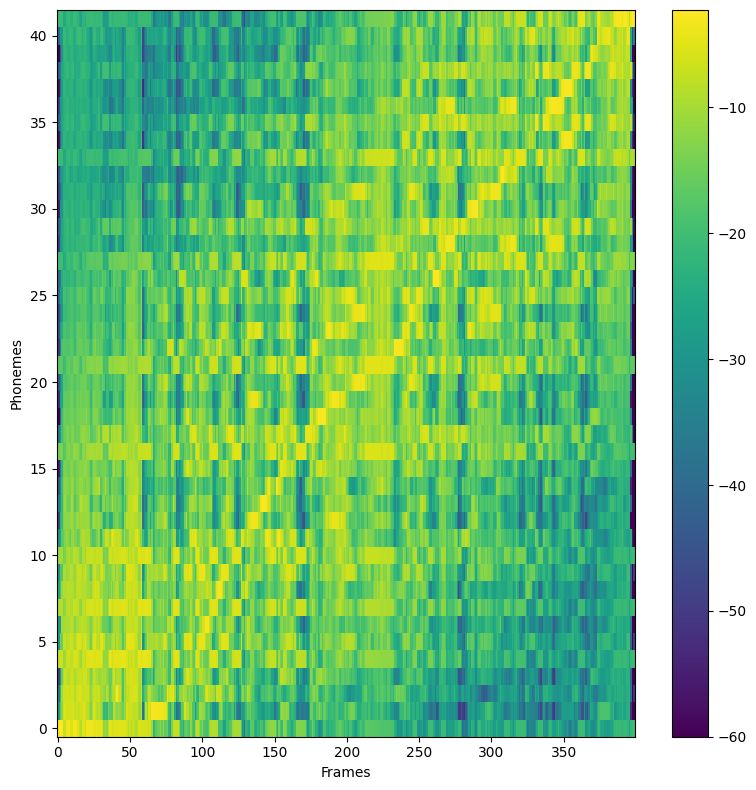

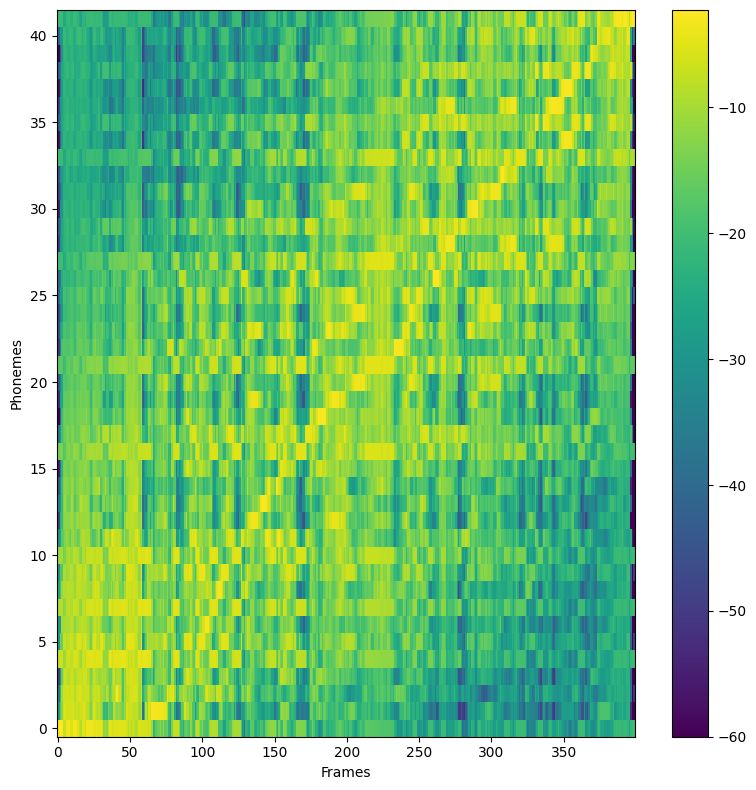

In [19]:
logits[logits < -60.] = -60.
pyfoal.plot.logits(logits[0].cpu())

In [ ]:
dd